In [2]:
from PIL import Image

from src.model import SiamNet, get_siamnet
from src.model import EfficientNetB3Encoder, CLIPEncoder
from src.dataset import get_augmentations, load_config, get_coco_dataloaders, CocoDataset
from src.train import train_model

%load_ext autoreload
%autoreload 2

/home/jovyan/.mlspace/envs/genimages/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Augmentations

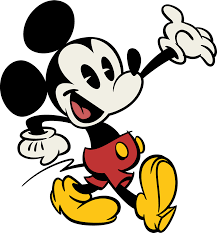

In [3]:
image = Image.open('assets/image.png').convert('RGB')
image

In [4]:
simple_transform, train_transform = get_augmentations()

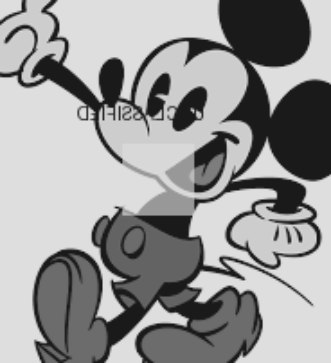

In [7]:
train_transform(image)

### Model

In [8]:
encoder = EfficientNetB3Encoder(freeze=True)
preprocess = encoder.preprocess

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

Loaded pretrained weights for efficientnet-b3
torch.Size([1, 3, 224, 224]) torch.Size([1, 1536])


In [10]:
encoder = CLIPEncoder(freeze=True)
preprocess = encoder.preprocess

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 512])


In [11]:
config = load_config('configs/train_config.yaml')
net = get_siamnet(config).to('cpu')
net(tensor, tensor)

Loaded pretrained weights for efficientnet-b3


tensor([[0.5054]], grad_fn=<ViewBackward0>)

### Data

In [12]:
path = '/home/jovyan/nkiselev/ddorin/project/Pairwise-Image-Matching/data'

config_path = "configs/train_config.yaml"
train_config = load_config(config_path)

net = get_siamnet(train_config)
preprocessor = net.get_preprocessing()

data = CocoDataset(path, preprocessor)

Loaded pretrained weights for efficientnet-b3


In [13]:
len(data)

258624

In [14]:
dataloaders = get_coco_dataloaders(path, 
                         preprocessor, 
                         batch_size=32, 
                         num_workers=4,
                         val_size=0.1, 
                         random_seed=42)